<img src="logo_ue.png" width="400"/>


# ANEXO 4
# 3. DESARROLLO DEL PROYECTO - 
## Word2Vec y Similitud del Coseno

In [1]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# --- Paso 1: Cargar datos ---


In [2]:
df_iniciativas = pd.read_excel("iniciativas_preprocesadas.xlsx")
df_proyectos = pd.read_excel("proyectos_preprocesados.xlsx")

In [3]:

# --- Paso 1: Tokenización ---
df_iniciativas["tokens"] = df_iniciativas["texto_preprocesado"].fillna("").apply(lambda x: x.split())
df_proyectos["tokens"] = df_proyectos["texto_preprocesado"].fillna("").apply(lambda x: x.split())

# --- Paso 2: Normalizar códigos DANE ---
def normalizar_codigos(campo):
    if pd.isna(campo):
        return []
    elif isinstance(campo, list):
        return [str(x).zfill(5) for x in campo]
    elif isinstance(campo, str):
        try:
            lista = ast.literal_eval(campo)
            return [str(x).zfill(5) for x in lista] if isinstance(lista, list) else [str(lista).zfill(5)]
        except:
            return [campo.zfill(5)]
    elif isinstance(campo, (int, float)):
        return [str(int(campo)).zfill(5)]
    return []

df_iniciativas["codigos_dane_list"] = df_iniciativas["codigosdane"].apply(normalizar_codigos)
df_proyectos["codigos_dane_list"] = df_proyectos["codigoentidadnormalizado"].apply(normalizar_codigos)

# --- Paso 3: Entrenar Word2Vec con todo el corpus ---
corpus_total = df_iniciativas["tokens"].tolist() + df_proyectos["tokens"].tolist()
corpus_total = [t for t in corpus_total if isinstance(t, list) and len(t) > 0 and all(isinstance(w, str) for w in t)]

modelo_w2v = Word2Vec(
    sentences=corpus_total,
    vector_size=50,
    window=3,
    min_count=1,
    workers=4,
    sg=1,
    seed=42
)

# --- Paso 4: Vector promedio por texto ---
def vector_promedio(tokens, modelo, dim=50):
    if not isinstance(tokens, list) or not tokens:
        return np.zeros(dim)
    vectores = [modelo.wv[word] for word in tokens if word in modelo.wv]
    return np.mean(vectores, axis=0) if vectores else np.zeros(dim)

df_iniciativas["vector"] = df_iniciativas["tokens"].apply(lambda x: vector_promedio(x, modelo_w2v))
df_proyectos["vector"] = df_proyectos["tokens"].apply(lambda x: vector_promedio(x, modelo_w2v))

# --- Paso 5: Crear índice de proyectos por código DANE ---
dane_to_proyectos = defaultdict(list)

for _, p_row in df_proyectos.iterrows():
    for dane in p_row["codigos_dane_list"]:
        dane_to_proyectos[dane].append(p_row)

# --- Paso 6: Comparar iniciativas solo con proyectos que compartan DANE ---
resultados_indexados = []

for _, i_row in tqdm(df_iniciativas.iterrows(), total=len(df_iniciativas), desc="Similitud Word2Vec con índice DANE"):
    dane_i = set(i_row["codigos_dane_list"])
    vector_i = i_row["vector"]
    comparados = set()  # para evitar duplicados si un proyecto aparece en varios DANE

    for dane in dane_i:
        for p_row in dane_to_proyectos.get(dane, []):
            p_key = p_row["bpin"]
            if p_key in comparados:
                continue
            comparados.add(p_key)

            vector_p = p_row["vector"]
            sim = cosine_similarity([vector_i], [vector_p])[0][0]
            resultados_indexados.append({
                "codigo_iniciativa": i_row["código_iniciativa"],
                "bpin": p_row["bpin"],
                "codigos_dane_compartidos": list(set(p_row["codigos_dane_list"]) & dane_i),
                "similitud_coseno": round(sim, 4)
            })

# --- Paso 7: Guardar en .CSV sin límites de filas ---
df_resultado_indexado = pd.DataFrame(resultados_indexados).sort_values(by="similitud_coseno", ascending=False)
df_resultado_indexado.to_csv("resultado_word2vec_indexado.csv", index=False)

print("✅ Resultado guardado como 'resultado_word2vec_indexado.csv'")



Similitud Word2Vec con índice DANE: 100%|██████████| 33007/33007 [2:38:24<00:00,  3.47it/s]   


✅ Resultado guardado como 'resultado_word2vec_indexado.csv'


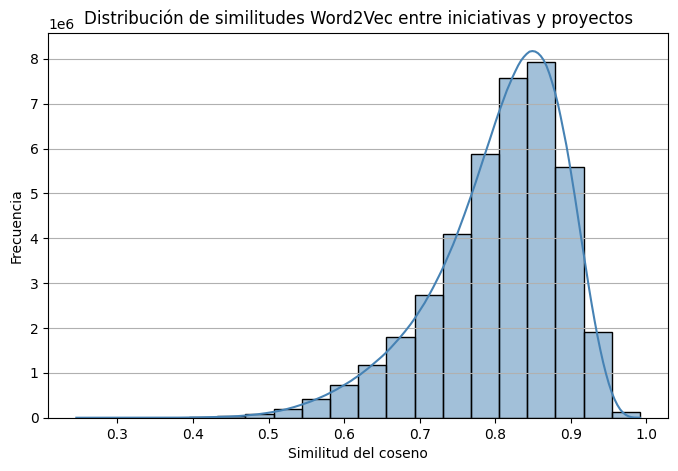

In [4]:
plt.figure(figsize=(8, 5))
sns.histplot(df_resultado_indexado['similitud_coseno'], bins=20, kde=True, color='steelblue')
plt.title("Distribución de similitudes Word2Vec entre iniciativas y proyectos")
plt.xlabel("Similitud del coseno")
plt.ylabel("Frecuencia")
plt.grid(axis='y')

plt.show()


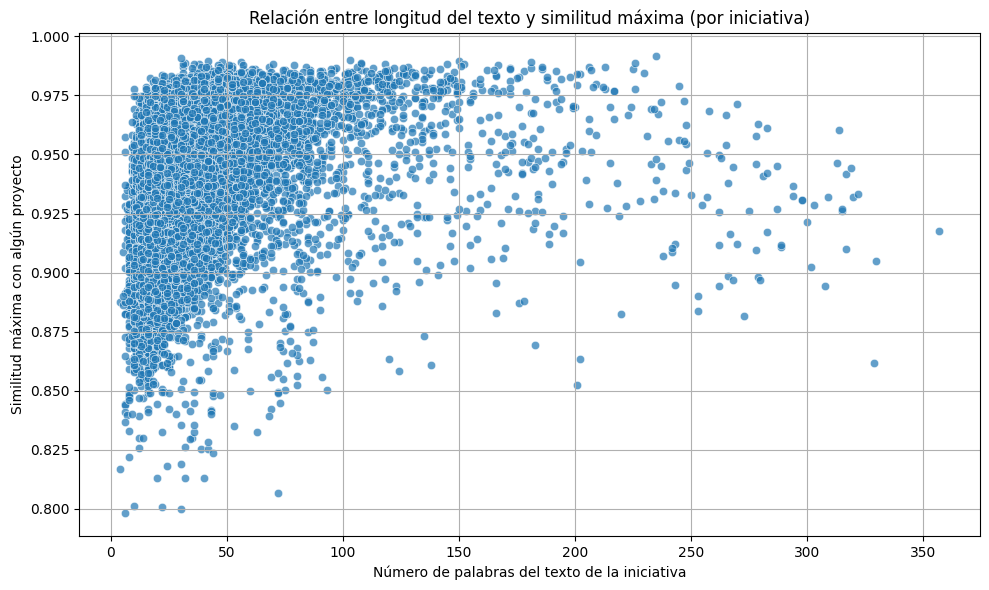

In [5]:
df_iniciativas['longitud_texto'] = df_iniciativas['texto_preprocesado'].astype(str).apply(lambda x: len(x.split()))
# Obtener la similitud máxima por iniciativa
df_max_sim = df_resultado_indexado.groupby('codigo_iniciativa')['similitud_coseno'].max().reset_index()
df_max_sim = df_max_sim.merge(df_iniciativas[['código_iniciativa', 'longitud_texto']], left_on='codigo_iniciativa', right_on='código_iniciativa', how='left')

# Graficar
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_max_sim, x='longitud_texto', y='similitud_coseno', alpha=0.7)
plt.title("Relación entre longitud del texto y similitud máxima (por iniciativa)")
plt.xlabel("Número de palabras del texto de la iniciativa")
plt.ylabel("Similitud máxima con algún proyecto")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Extraer top 10 y unir textos
top_10 = df_resultado_indexado.sort_values(by="similitud_coseno", ascending=False).head(10)

top_10 = top_10.merge(df_iniciativas[["código_iniciativa", "texto_preprocesado"]],
                      left_on="codigo_iniciativa", right_on="código_iniciativa", how="left") \
               .merge(df_proyectos[["bpin", "texto_preprocesado"]],
                      on="bpin", how="left", suffixes=("_iniciativa", "_proyecto"))

top_10 = top_10[["codigo_iniciativa", "bpin", "similitud_coseno",
                 "texto_preprocesado_iniciativa", "texto_preprocesado_proyecto"]]

top_10.rename(columns={
    "codigo_iniciativa": "Código Iniciativa",
    "bpin": "BPIN Proyecto",
    "similitud_coseno": "Similitud Coseno",
    "texto_preprocesado_iniciativa": "Texto Iniciativa",
    "texto_preprocesado_proyecto": "Texto Proyecto"
}, inplace=True)

pd.set_option('display.max_colwidth', None)
display(top_10)



,Código Iniciativa,BPIN Proyecto,Similitud Coseno,Texto Iniciativa,Texto Proyecto
0,119450291328,2022003190103,0.9918,fortalecer linea_productivo cacao establecimiento mantenimiento cultivo comercializacion cacao_tostado molido municipio_mercader cauca fortalecer linea_productivo cacao establecimiento mantenimiento cultivo comercializacion cacao_tostado molido municipio_mercader caucar siguiente accion promover cadena_productivo cacao familia productor suministro_insumos entrega_semilla mejorada conservacion_semilla nativo construccion vivero produccion material mejorado manejo_fitosanitario fermentacion beneficio equipo agricola fumigadora_guadana cava hoyo herramienta menor machete_palo pico capacitacion tecnificacion_agricola extension_rural eficiente proceso siembra produccion_comercializacion buscar sostenibilidad mercado miras desarrollo rural municipio planta tostadora cacao incluir plan funcionamiento procesamiento_transformacion cacao familia productor planta contar debido instalacion tecnologico maquinario utensilio adecuado proceso productivo tostadora molino bola prensadora moledora mezcladora masa empacadora asimismo deber dotar el estiba_secado almacenamiento dotacion vehiculo_transporte recoleccion cacao finca productor entregar planta_procesamiento paso requerir acompanamiento extension_agropecuario permanente proceso generacion_valor comercializacion mercado_local municipal regional asociatividad desarrollar componente_socioempresarial fortalecer pequeno_productor componente organizacion tecnico administrativo_financiero mercadeo_comercializacion garantizar adecuado gestion actividad productivo fortalecimiento ampliacion base social generacion servicio asociado cacao utilizar cultivo generador_ingreso conservacion medioambiental especie demandar cantidad agroquimico captador dioxido_carbono caracteristica permitir contribuir_reduccion gas_efecto invernadero principal responsable cambio_climatico demostrado siembra_cacao recuperan especie_fauna territorio cacao emplear zona estrategia sustitucion_cultivo ilicito implementar accion fortalecimiento_capacidad organizacional rural municipio_mercader cauco requerir apoyo organizacion municipio junto_accion comunal_asociacion productor consejo_comunitario fundacion_cooperativo poder contratar directamente jac entidad caracter_privado cooperacion_internacional ejecucion recurso proyecto involucrar lograr capacitacion proceso administrativo extension_rural formulacion ejecucion_proyecto social convocatoria caracter_regional nacional contribuir crecimiento dicho organizacion dotar_equipo computo_mobiliario funcionamiento generar crecimiento social_economico sector sentido requerir amnistia organizacion desconocimiento_norma encontrar reportada entidad diar_camara comercio ley cumplir el participacion jac,fortalecimiento produccion mora_castilla alto calidad departamento_caucir proyecto objetivo mejorar competitividad productor mora_castilla departamento_cauca suministro_material insumos proceso productivo mora_castilla acompanamiento profesional prestacion_servicio extension_agropecuario etapa productivo comercial buscar implementar fortalecida producir ano_tonelada beneficiar productor municipio beneficiado planta hectarea indicar ton mora_castilla alto calidad generar incremento_produccion lograr aplicacion plan adecuado fertilizacion_control plaga asistencia_tecnico redundacer incremento_rendimiento calidad mora obtenido contemplar implementacion taller_practico participativo tematico incluir demostracion_metodo etapa cultivo permitir incrementar competencia productor manejo_agronomico cultivo_mora sostenibilidad capacitar_beneficiario tematica indole comercial_agroindustria mejorar funcionamiento asociacion unidad_productivo taller dicho actividad permitir sistema produccion departamento sostenible plazo generar redito superior actualmente obtener ejercicio labor agropecuario ventaja adicional alternativa dotacion centro_acopio cuarto_frio localizado_quince municipi

# Determinar rango

In [8]:
df = df_resultado_indexado
df = df.rename(columns={"similitud_coseno": "similitud"})


# Calcular percentiles principales
percentiles = df["similitud"].quantile([0.25, 0.5, 0.75, 0.90, 0.95, 0.99]).round(4)
print("Percentiles de similitud:")
print(percentiles)


Percentiles de similitud:
0.25    0.7583
0.50    0.8207
0.75    0.8678
0.90    0.9008
0.95    0.9173
0.99    0.9429
Name: similitud, dtype: float64


In [9]:
# Definir rangos de similitud
bins = [0.0, 0.6, 0.7, 0.75, 0.80, 0.85, 0.90, 0.95, 1.0]
labels = ["<0.6", "0.6–0.7", "0.7–0.75", "0.75–0.8", "0.8–0.85", "0.85–0.9", "0.9–0.95", "0.95–1.0"]
df["rango_similitud"] = pd.cut(df["similitud"], bins=bins, labels=labels, include_lowest=True)

# Calcular frecuencia por rango
frecuencia_rangos = df["rango_similitud"].value_counts().sort_index()
print("\nFrecuencia por rango de similitud:")
print(frecuencia_rangos)



Frecuencia por rango de similitud:
rango_similitud
<0.6         1058255
0.6–0.7      3822862
0.7–0.75     4247853
0.75–0.8     7091243
0.8–0.85    10144683
0.85–0.9     9787475
0.9–0.95     3927583
0.95–1.0      210660
Name: count, dtype: int64


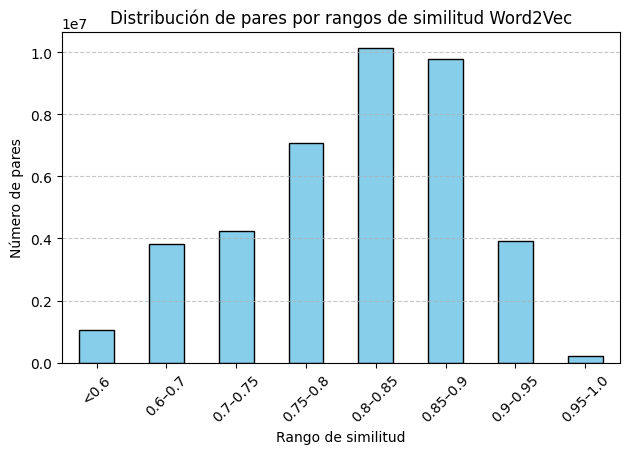

In [10]:


# Gráfico de barras por rango de similitud
frecuencia_rangos.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribución de pares por rangos de similitud Word2Vec")
plt.xlabel("Rango de similitud")
plt.ylabel("Número de pares")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


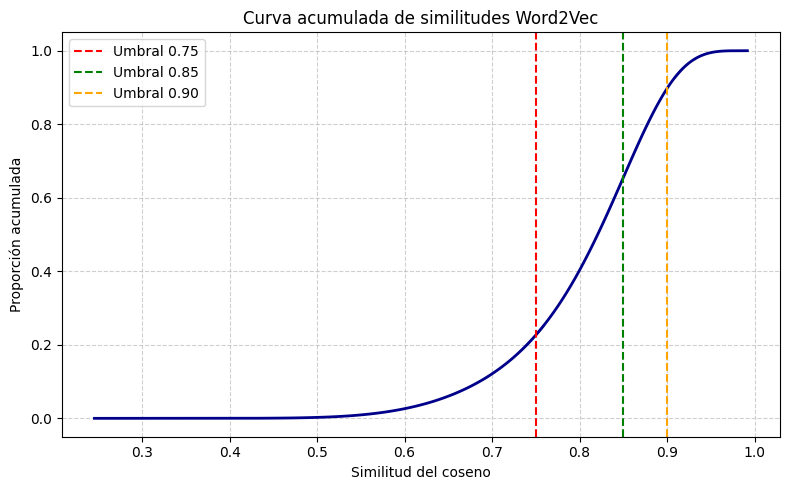

In [11]:

# Ordenar las similitudes
similitudes_ordenadas = np.sort(df["similitud"].values)

# Calcular valores acumulados
frecuencia_acumulada = np.arange(1, len(similitudes_ordenadas) + 1) / len(similitudes_ordenadas)

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(similitudes_ordenadas, frecuencia_acumulada, color='darkblue', linewidth=2)
plt.axvline(x=0.75, color='red', linestyle='--', label='Umbral 0.75')
plt.axvline(x=0.85, color='green', linestyle='--', label='Umbral 0.85')
plt.axvline(x=0.90, color='orange', linestyle='--', label='Umbral 0.90')
plt.title("Curva acumulada de similitudes Word2Vec")
plt.xlabel("Similitud del coseno")
plt.ylabel("Proporción acumulada")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
